In [2]:
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap

from jax import random

from jax.config import config

from jax_tqdm import loop_tqdm

import functools

config.update("jax_debug_nans", True)


C:\Users\jakob\AppData\Local\Temp\ipykernel_20408\1745627592.py:7: DeprecationWarning: Accessing jax.config via the jax.config submodule is deprecated.
  from jax.config import config


(300, 3) (300, 3) (300, 3)
-11.967346
[[[-1.0242355e+01  4.5565224e+01 -1.7384647e+01]
  [ 3.3121095e+00  4.8298451e-01  0.0000000e+00]
  [ 2.0995157e+00  5.0838537e+00  0.0000000e+00]]

 [[-1.6594052e+00  4.3135750e+01  1.2557829e+01]
  [ 1.3829482e+00  3.8895941e+00  0.0000000e+00]
  [ 5.5517888e+00  3.7618918e+00  0.0000000e+00]]

 [[ 3.4773922e+01 -1.3954473e+01 -4.0117443e+01]
  [ 1.9247939e-01  9.3504298e-01  0.0000000e+00]
  [ 4.7322431e+00  1.7676245e+00  0.0000000e+00]]

 ...

 [[ 4.1365242e+01 -3.8396835e+00  2.5789536e+01]
  [ 1.2106607e+00  1.1520548e+00  0.0000000e+00]
  [ 2.2278788e+00  2.2807651e+00  0.0000000e+00]]

 [[-3.6113857e+01  3.1331312e+01  2.0793867e+01]
  [ 6.0558591e+00  4.7513380e+00  0.0000000e+00]
  [ 1.4443187e+00  3.7132883e+00  0.0000000e+00]]

 [[-4.8652447e+01  3.2212387e+01  2.5557686e+01]
  [ 2.4254701e+00  4.3393381e-02  0.0000000e+00]
  [ 1.7315782e+00  6.0227008e+00  0.0000000e+00]]]


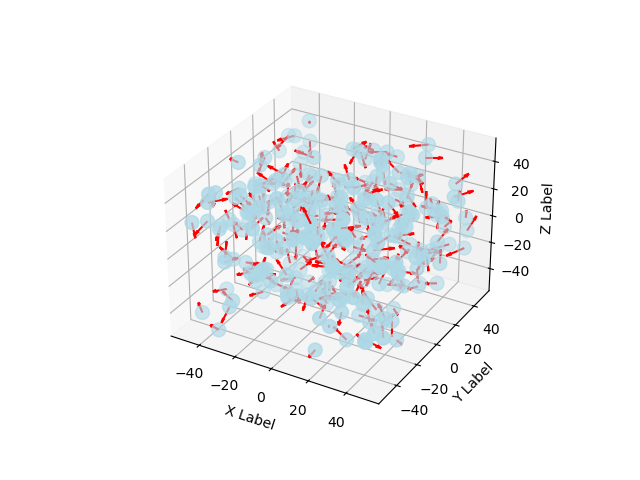

Traced<ShapedArray(float32[300])>with<DynamicJaxprTrace(level=2/0)>


  0%|          | 0/10000 [00:00<?, ?it/s]

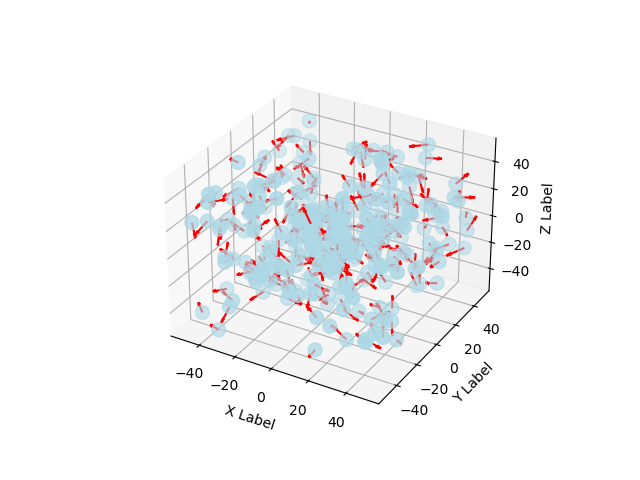

-946.0189


Array([[[-1.08996620e+01,  4.51340904e+01, -1.40619040e+01],
        [ 2.72943163e+00,  8.61257076e-01, -4.84638393e-01],
        [ 1.70166767e+00,  6.13026094e+00, -3.89657736e-01]],

       [[-7.71732664e+00,  1.06701660e+01,  5.71167707e+00],
        [-2.68851471e+00,  4.70143986e+00,  9.76185131e+00],
        [-2.98093438e-01,  1.09119005e+01,  3.09210658e+00]],

       [[ 3.47083549e+01, -1.39148798e+01, -3.99972801e+01],
        [-3.06422830e-01,  1.02414203e+00, -7.72277862e-02],
        [ 4.75706530e+00,  1.75341487e+00, -6.75547495e-02]],

       ...,

       [[ 4.05443535e+01, -3.80819964e+00,  2.51516819e+01],
        [ 1.06021106e+00,  2.03576589e+00,  3.38899463e-01],
        [ 2.64386487e+00,  2.27653646e+00,  2.98966736e-01]],

       [[-3.63293419e+01,  3.15374622e+01,  2.10760746e+01],
        [ 6.05844259e+00,  4.99177694e+00, -4.23001468e-01],
        [ 1.55766320e+00,  3.62328553e+00, -5.75633422e-02]],

       [[-4.86524467e+01,  3.22123871e+01,  2.55576859e+01],
 

In [7]:
%matplotlib widget

G = {
    "beta": 5.0,
    "lambda0": 1.0,
    "lambda1": 0.0,
    "lambda2": 0.0,
    "dt": 0.1,
    "eta": 0.01, # width of the gaussian noise
}

@jit
def unpack_cellrow(cellrow : jnp.ndarray) -> tuple[jnp.ndarray, jnp.ndarray, jnp.ndarray]:
    pos = cellrow[0]
    p = cellrow[1]
    q = cellrow[2]
    return pos, p, q

@jit
def quadruple(a1, a2, b1, b2) -> float: 
    return jnp.dot(jnp.cross(a1, b1), jnp.cross(a2, b2))
@jit
def V(r : float, S : float) -> float:
    return jnp.exp(-r) - S * jnp.exp(- r / G["beta"])

@jit
def S(r, p1, q1, p2, q2) -> float:
    S1 = quadruple(p1, p2, r, r)
    S2 = quadruple(p1, p2, q1, q2)
    S3 = quadruple(q1, q2, r, r)

    return G["lambda0"]*S1 + G["lambda1"]*S2 + G["lambda2"]*S3


def from_angles_to_vector(alpha, beta) -> jnp.ndarray:
    x = jnp.cos(alpha)*jnp.cos(beta)
    y = jnp.sin(alpha)*jnp.cos(beta)
    z = jnp.sin(beta)
    return jnp.array([x, y, z])
@jit
def U(cellrow1 : jnp.ndarray, cellrow2 : jnp.ndarray) -> float:

    pos1, p_angles1, q_angles1 = unpack_cellrow(cellrow1)
    pos2, p_angles2, q_angles2 = unpack_cellrow(cellrow2)
    
    p1 = from_angles_to_vector(p_angles1[0], p_angles1[1])
    q1 = from_angles_to_vector(q_angles1[0], q_angles1[1])

    p2 = from_angles_to_vector(p_angles2[0], p_angles2[1])
    q2 = from_angles_to_vector(q_angles2[0], q_angles2[1])

    dir = pos2 - pos1

    s = S(dir, p1, q1, p2, q2)
    
    _dir = jnp.where(jnp.allclose(dir, jnp.zeros(3)), jnp.array([1, 0, 0]), dir)

    r = jnp.linalg.norm(_dir)

    v = V(r, s)

    v_corrected = jnp.where(jnp.allclose(dir, jnp.zeros(3)), 0.0, v)

    return v_corrected


def get_IC(N : int) -> jnp.ndarray:

    # N random uniform points in 3D
    key = random.PRNGKey(0)
    pos = (random.uniform(key, (N, 3))*2 - 1)*50

    # N vectors pointing up
    # p = jnp.repeat(jnp.array([[0, 0, 1]]), N, axis=0)

    # N random angles between 0 and 2pi
    p = random.uniform(key, (N, 2))*2*jnp.pi


    # N random angles between 0 and 2pi
    key = random.PRNGKey(1)

    q = random.uniform(key, (N, 2))*2*jnp.pi

    # add a zero to the end of p and q
    p = jnp.concatenate([p, jnp.zeros((N, 1))], axis=1)
    q = jnp.concatenate([q, jnp.zeros((N, 1))], axis=1)

    # combine them

    print(pos.shape, p.shape, q.shape)
    cells = jnp.stack([pos, p, q], axis=1)

    return cells


@functools.partial(jit, static_argnames=["k", "recall_target"])
def l2_ann(qy, db,  k=10, recall_target=0.95):
    half_db_norms = jnp.linalg.norm(db, axis=1)**2 / 2
    dists = half_db_norms - jax.lax.dot(qy, db.transpose())
    return jax.lax.approx_min_k(dists, k=k, recall_target=recall_target)




# compute the energy of the system
@jit
def U_sum(cells : jnp.ndarray):
    # use the jax map function to compute the energy of each cell
    positions = cells[:,0,:]


    dists, neighbors = l2_ann(positions, positions, k=6)


    U_cells = vmap(U)(cells[neighbors], cells)


    # jax.debug.breakpoint()
    # print(neighbors.shape)

    # U_cells = vmap(lambda c: U(neighbors,c ))

    # YYY = U_cells(cells)
    # print(YYY)

    # # set the diagonal to zero
    # # YYY = jnp.fill_diagonal(YYY, 0.0, inplace=False, )

    # # only take the upper triangle
    # YYY = jnp.triu(YYY)

    # # # sum the energies
    final_sum = jnp.sum(U_cells)


    return final_sum
    # return U_total


U_grad = grad(U_sum)

@jit
def take_step(cells : jnp.ndarray):
    # print the energy using jax.debug
    # jax.debug.print(str(jax.lax.stop_gradient(U_sum(cells)).astype(float)))
    # compute the gradient of the energy
    grad_U = U_grad(cells)

    # update the positions
    cells = cells - grad_U*G["dt"] 

    # add random noise to the positions
    cells.at[:,0,:].add(random.normal(random.PRNGKey(0), cells.shape[0:2])*G["eta"])

    # normalize p and qcc
    # jax.debug.breakpoint()

    # print magnitude of the cells positions
    print(jnp.linalg.norm(cells[:,1,:], axis=1))

    return cells


def main(N_cells : int, N_steps : int):
    cells = get_IC(N_cells)
    print(U_sum(cells))
    print(cells)
    plot_cells(cells)

    @loop_tqdm(N_steps)
    def jaxstep(i, cells):
        return take_step(cells)

    cells = jax.lax.fori_loop(0, N_steps,jaxstep, cells)
    plot_cells(cells)

    print(U_sum(cells))
    return cells

main(300, 10000)


In [3]:
import matplotlib.pyplot as plt

# 3d plot of the cells
def plot_cells(cells : jnp.ndarray):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(cells[:, 0, 0], cells[:, 0, 1], cells[:, 0, 2], c='lightblue', marker='o', s=100)
    # draw the vectors
    for i in range(cells.shape[0]):
        pos = cells[i, 0, :]
        p_angles = cells[i, 1, :]
        p = from_angles_to_vector(p_angles[0], p_angles[1])
        q_angles = cells[i, 2, :]
        q = from_angles_to_vector(q_angles[0], q_angles[1])
        # print(pos, p, q)
        ax.quiver(pos[0], pos[1], pos[2], p[0], p[1], p[2], length=10, normalize=True, color='red')
        # ax.quiver(pos[0], pos[1], pos[2], q[0], q[1], q[2], length=10, normalize=True, color='blue')
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    plt.show()


plot_cells(main(7, 2))

NameError: name 'main' is not defined